# Network Intrusion Detection using GRU

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, GRU, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
# representation of model layers
from keras.utils.vis_utils import plot_model

### Reading Data

In [2]:
#Add the column labels
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

### Fetching the files

In [3]:
train='KDDTrain+.txt'
test='KDDTest+.txt'
test21='KDDTest-21.txt'

train_data=pd.read_csv(train,names=feature)
test_data=pd.read_csv(test,names=feature)
test_data21 = pd.read_csv(test21, names= feature)
data= pd.concat([train_data, test_data], ignore_index=True)

In [4]:
data.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


### Exploring Data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [6]:
# remove attribute 'difficulty_level'
data.drop(['difficulty'],axis=1,inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,148517.0,276.779305,2.460683e+03,0.0,0.00,0.00,0.00,5.771500e+04
src_bytes,148517.0,40227.949299,5.409612e+06,0.0,0.00,44.00,278.00,1.379964e+09
dst_bytes,148517.0,17088.853593,3.703525e+06,0.0,0.00,0.00,571.00,1.309937e+09
land,148517.0,0.000215,1.467714e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,148517.0,0.020523,2.400691e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,148517.0,0.000202,1.941708e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,148517.0,0.189379,2.013160e+00,0.0,0.00,0.00,0.00,1.010000e+02
num_failed_logins,148517.0,0.004323,7.224823e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,148517.0,0.402789,4.904606e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,148517.0,0.255062,2.223137e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [9]:
# number of attack labels 
data['label'].value_counts()

normal             77054
neptune            45871
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm               2


### Redistribute across common attack class

In [10]:
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [11]:
change_label(data)

In [12]:
# distribution of attack classes
data.label.value_counts()

normal    77054
Dos       53387
Probe     14077
R2L        3880
U2R         119
Name: label, dtype: int64

### Creating Multi-class labels

In [13]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(data.label)

In [14]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = data.select_dtypes(include='number').columns
data = standardization(data,numeric_col)

In [15]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)
data.head(5)

(148517, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,normal,4
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,Dos,0
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,normal,4
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,normal,4


In [16]:
data.drop(labels= ['label'], axis=1, inplace=True)
print(data.shape)

(148517, 42)


In [17]:
# one-hot-encoding categorical columns
data = pd.get_dummies(data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  
print(data.shape)

(148517, 123)


In [18]:
y_data= data['intrusion']
X_data= data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_data.shape,'\ny_train has shape:',y_data.shape)

X_train has shape: (148517, 122) 
y_train has shape: (148517,)


In [19]:
from sklearn.preprocessing import LabelBinarizer
y_data = LabelBinarizer().fit_transform(y_data)

X_data=np.array(X_data)
y_data=np.array(y_data)

In [20]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.20, random_state=42)
print(X_train.shape,'\n',X_test.shape)

(118813, 122) 
 (29704, 122)


In [21]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, ( X_train.shape[0], 1 , X_train.shape[1] ))
X_test = np.reshape(X_test, ( X_test.shape[0], 1,  X_test.shape[1] ))

### Applying GRU Algorithms

In [22]:
model = Sequential() # initializing model
model.add(GRU(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))

# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

In [23]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# summary of model layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 64)             36096     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 1, 64)             24960     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 gru_2 (GRU)                 (None, 1, 64)             24960     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3

###  Training the model

In [25]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 15s 245ms/step - loss: 1.2694 - accuracy: 0.7789 - val_loss: 0.6709 - val_accuracy: 0.8456
Epoch 2/100
20/20 [==============================] - 2s 110ms/step - loss: 0.4699 - accuracy: 0.8616 - val_loss: 0.3472 - val_accuracy: 0.9147
Epoch 3/100
20/20 [==============================] - 2s 124ms/step - loss: 0.2925 - accuracy: 0.9198 - val_loss: 0.2346 - val_accuracy: 0.9274
Epoch 4/100
20/20 [==============================] - 3s 126ms/step - loss: 0.2174 - accuracy: 0.9357 - val_loss: 0.1865 - val_accuracy: 0.9476
Epoch 5/100
20/20 [==============================] - 3s 128ms/step - loss: 0.1787 - accuracy: 0.9458 - val_loss: 0.1578 - val_accuracy: 0.9495
Epoch 6/100
20/20 [==============================] - 3s 127ms/step - loss: 0.1525 - accuracy: 0.9510 - val_loss: 0.1350 - val_accuracy: 0.9538
Epoch 7/100
20/20 [==============================] - 3s 138ms/step - loss: 0.1326 - accuracy: 0.9539 - val_loss: 0.1152 - val_accuracy: 0.954

Epoch 58/100
20/20 [==============================] - 3s 142ms/step - loss: 0.0404 - accuracy: 0.9865 - val_loss: 0.0398 - val_accuracy: 0.9880
Epoch 59/100
20/20 [==============================] - 3s 139ms/step - loss: 0.0413 - accuracy: 0.9861 - val_loss: 0.0396 - val_accuracy: 0.9870
Epoch 60/100
20/20 [==============================] - 3s 143ms/step - loss: 0.0405 - accuracy: 0.9868 - val_loss: 0.0392 - val_accuracy: 0.9879
Epoch 61/100
20/20 [==============================] - 3s 143ms/step - loss: 0.0400 - accuracy: 0.9867 - val_loss: 0.0394 - val_accuracy: 0.9880
Epoch 62/100
20/20 [==============================] - 3s 146ms/step - loss: 0.0401 - accuracy: 0.9867 - val_loss: 0.0404 - val_accuracy: 0.9866
Epoch 63/100
20/20 [==============================] - 4s 188ms/step - loss: 0.0408 - accuracy: 0.9863 - val_loss: 0.0391 - val_accuracy: 0.9875
Epoch 64/100
20/20 [==============================] - 3s 152ms/step - loss: 0.0398 - accuracy: 0.9870 - val_loss: 0.0393 - val_accuracy:

In [26]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 [==============================] - 5s 6ms/step - loss: 0.0374 - accuracy: 0.9874
Test results - Loss: 0.0374053418636322 - Accuracy: 98.74091148376465%


### Plot of Accuracy

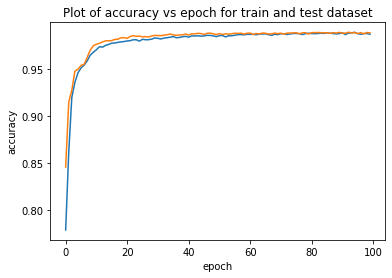

In [27]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

### Plot of loss

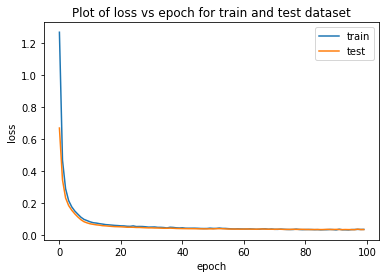

In [28]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()